# A Python notebook for extracting and manipulating Macrostrat data


## Author

- Author1 = {"name": "Shan Ye", "affiliation": "University of Wisconsin-Madison", "email": "shan.ye@wisc.edu", "orcid": ""}
    


## Purpose
This Python Jupyter notebook is built as a demo to illustrate how to extract column data through the Macrostrat API and how to process and visualize them. It contains functions for data wrangling, tabulating, bootstrapping sampling, and visualization. By providing useful examples and Python scripts, this notebook could promote the Macrostrat database in the geology and paleontology communities.

## Technical contributions
- building time series of spatial coverages of marine and non-marine sediments in Phanerozoic North America, 
- building time series of spatial coverages of siliciclastic and carbonate lithologies throughout the Mesozoic North America
- bootstrapping samplings and visualizations of these time series 

## Methodology
NA

## Results
This notebook provides some Python codes to retrieve and manipulate data from Macrostrat, especially to remove over-counted columns (due to their multiple environmental and/or lithological attributes within a single time step) when constructing the time series. There are no scientific results. Demo results are shown in the code section.

## Funding
NA

## Keywords

keywords=["Macrostrat", "time-series", "stratigraphy", "lithology", "paleoenvironment"]

## Citation
Shan Ye, 2021, A Python notebook for extracting and manipulating Macrostrat data.

## Work In Progress - improvements

- todo 1; Retrieving and visualizing geological map data (waiting for the finalization of the new Macrostrat API routes)
- todo 2: Retrieve data from other geoscience databases (like the PBDB) and perform time series statistics (like Pearson's r) between data from different sources


## Suggested next steps
State suggested next steps, based on results obtained in this notebook. This section is optional.

## Acknowledgements 
The Macrostrat group at the University of Wisconsin-Madison, supervised by Dr. Shanan Peters.


# Setup

## Library import
Import all the required Python libraries.

The code cell below is an example.

In [1]:
import json
import requests
import re
import builtins
import pandas as pd
import numpy as np
from random import choices
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output
import geopandas as gpd
import plotly

# Parameter definitions
NA


# Data import
Data are retrieved from the Macrostrat database via its api (https://macrostrat.org/#api).


# Data processing and analysis
The core of the notebook is here. Split this section into subsections as required, and explain processing and analysis steps.


### Function 1: get data from the Macrostrat API and turn it into the json format
There are different levels of the lithological classification.

Regular expression is used to detect the level of lithology requested by the user.

This function returns 3 things in the following order:

- the json file
- the detected level of lithology
- the detected lithological name

These results will be used in the next function.

In [2]:
def get_json(api):
    j = requests.get(api)
    l_level = "all"
    l_name = "any"
    
    if "lith_type" in api:
        x = re.search("(?<=lith_type=)[a-zA-Z]*", api)
        l_level = "lith_type"
        l_name = x.group()
    elif "lith=" in api:
        x = re.search("(?<=lith=)[a-zA-Z]*", api)
        l_level = "lith_name"
        l_name = x.group()
    elif "lith_class" in api:
        x = re.search("(?<=lith_class=)[a-zA-Z]*", api)
        l_level = "lith_class"
        l_name = x.group()
    return j.json(), l_level, l_name

### Function 2: Process the returned json file and extract relevant column data
The Function 1 is embedded within this function, so users do not need to call the api twice.

This function returns a dataframe containing raw column data. 

This dataframe will be used in the next function.

In [3]:
def col_json_proc(api):
    
    print("Reading api...")
    temp, l_level, l_name = get_json(api)
    df = pd.DataFrame()
    nrows = []
    
    for i in range(len(temp['success']['data'])):
        
        clear_output(wait = True)
        
        new_line = temp['success']['data'][i]['lith']
        nrow = len(temp['success']['data'][i]['lith'])
        df = df.append(pd.DataFrame(data = new_line))
        nrows.append(nrow)
        print('Extracting data from api...',np.round(i/len(temp['success']['data'])*100,1),'%')
        
    all_unit_ids = []
    for i in range(len(temp['success']['data'])):
        all_unit_ids.append(temp['success']['data'][i]['unit_id'])
        
    s = np.array(all_unit_ids)
    df['unit_id'] = list(np.repeat(s, nrows, axis=0))
    df = df.sort_values('unit_id')
    
    clear_output(wait = True)
    print("Processing lithology...")
    l = []
    if l_level == "lith_type":
        for i in range(len(df)):
            if df["type"].iloc[i] == l_name:
                l.append(i)
    elif l_level == "lith_class":
        for i in range(len(df)):
            if df["class"].iloc[i] == l_name:
                l.append(i)
    elif l_level == "lith_name":
        for i in range(len(df)):
            if df["name"].iloc[i] == l_name:
                l.append(i)
    else:
        for i in range(len(df)):
            l.append(i)

    df_sub = df.iloc[l]
    
    clear_output(wait = True)
    print("Processing prop...")
    prop_pivot = list(df_sub.pivot_table( columns='unit_id', values='prop', aggfunc='sum').iloc[0])
    for i in range(len(prop_pivot)):
        if prop_pivot[i] > 1:
            prop_pivot[i] = 1
    
    clear_output(wait = True)
    print("Assembling the data frame...")
    all_col_ids = []
    all_unit_ids = []
    all_t_age = []
    all_b_age = []
    all_max_thick = []
    all_min_thick = []
    all_pbdb_collections = []
    all_col_area = []
    for i in range(len(temp['success']['data'])):
        all_col_ids.append(temp['success']['data'][i]['col_id'])
        all_unit_ids.append(temp['success']['data'][i]['unit_id'])
        all_t_age.append(temp['success']['data'][i]['t_age'])
        all_b_age.append(temp['success']['data'][i]['b_age'])
        all_max_thick.append(temp['success']['data'][i]['max_thick'])
        all_min_thick.append(temp['success']['data'][i]['min_thick'])
        all_pbdb_collections.append(temp['success']['data'][i]['pbdb_collections'])
        all_col_area.append(temp['success']['data'][i]['col_area'])
        
    df2 = pd.DataFrame()
    df2['col_id'] = all_col_ids
    df2['unit_id'] = all_unit_ids
    df2['t_age'] = all_t_age
    df2['b_age'] = all_b_age 
    df2['max_thick'] = all_max_thick
    df2['min_thick '] = all_min_thick 
    df2['pbdb_collections'] = all_pbdb_collections
    df2['col_area'] = all_col_area
    df2 = df2.sort_values('unit_id')
    df2['prop'] = prop_pivot
    
    return df2


### Function 3: Converting the raw column data to the time series data, with bootstrapping sampling
This function will be directly used by the user.

It has 2 arguments:
- the raw column data returned from the Function 2
- the number of iterations for the bootstrapping sampling

It will return a dataframe the following fields for each of the 1 million year time step from 540 Ma to the present:
- the mean number of columns
- the standard deviation of the number of columns
- the mean number of stratigraphic units
- the standard deviation of the number of stratigraphic
- the mean column area
- the standard deviation of column area

In [4]:
def get_time_series(df2, bs):
    steps = list(range(3000))
    t = 540
    n = len(df2)
    sample = list(range(n))
    
    res = np.ndarray(shape=(bs,t,3), dtype=float)
    
    for b in range(bs):
        print("Processing boostrapping reps:", b+1, "out of", bs)
        if b > 1:
            sample = np.random.choice(list(range(n)), n, replace=True)
        packages = df2.iloc[sample]
    
        total_cols,total_packages,total_area = [],[],[]
    
        for i in range(t):
            cand = []
            for j in range(len(packages)):
                if packages['b_age'].iloc[j] >= steps[i]+1 and packages['t_age'].iloc[j] < steps[i]+1:
                    cand.append(j)
            col_cand = packages['col_id'].iloc[cand]
            total_cols.append(len(set(col_cand)))
            total_packages.append(len(cand))
        
            if total_cols[i] > 1:
                freq = Counter(col_cand)
                df_col = pd.DataFrame(freq.keys(),columns=['col_id'])
                df_col['Freq'] =freq.values()
                df_col.rename(columns={'A':'col_id','B':'Freq'})
                df_col_cand = pd.DataFrame(col_cand)
                col_temp = df_col.merge(df_col_cand, left_on='col_id', right_on='col_id')
                cols = col_temp['Freq']
            else:
                cols = [1] * len(cand)
            
            t_area = 0
            for j in range(len(packages['col_area'].iloc[cand])):
                if total_cols[i] > 1:
                    t_area += (packages['col_area'].iloc[cand].iloc[j]/col_temp['Freq'].iloc[j])
                else:
                    t_area += (packages['col_area'].iloc[cand].iloc[j])
                               
            total_area.append(t_area) 
            
            clear_output(wait = True)
            print("boostrapping reps:", b+1,'...', np.round(i/t*100,1),'%')
        
        np1 = np.array(total_cols)
        np2 = np.array(total_packages)
        np3 = np.array(total_area)
        
        stack = np.stack((np1, np2, np3), axis=1)
    
        res[b] = stack 
        
    clear_output(wait = True)
    print('calculating mean and std...')
    mean_all = np.mean(res, axis=0)
    std_all = np.std(res, axis=0)
    
    clear_output(wait = True)
    print('finalizing the result...')
    col_mean, col_std, package_mean, package_std, area_mean, area_std = [],[],[],[],[],[]
    for i in range(len(mean_all)):
        col_mean.append(mean_all[i][0])
        package_mean.append(mean_all[i][1])
        area_mean.append(mean_all[i][2])
        col_std.append(std_all[i][0])
        package_std.append(std_all[i][1])
        area_std.append(std_all[i][2])
    
    res_ts = pd.DataFrame()
    res_ts['time'] = range(1,541)
    res_ts['col_mean'] = col_mean
    res_ts['col_std'] = col_std
    res_ts['package_mean'] = package_mean
    res_ts['package_std'] = package_std
    res_ts['area_mean'] = area_mean
    res_ts['area_std'] = area_std
    
    clear_output(wait = True)
    return res_ts

### Function 4: Creating a map of a specific time step

This function is to plot a map showing the spatial coverage of the specific lithology or environment at the given time.

This function has 3 arguments:
- The API route
- The time (in Ma)
- The color for columns with positive values (optional; the default is brown color)

In [5]:
def plot_col(api, age, color = "brown"):
    df = col_json_proc(api)
    clear_output(wait = True)
    col = gpd.read_file('data/col.geojson')
    col['color'] = 0
    selected_col = []
    for row in df.iterrows():
        if row[1]['t_age'] < age and row[1]['b_age'] >= age:
            if int(row[1]['col_id']) not in selected_col:
                selected_col.append(int(row[1]['col_id']))
    for i in range(len(col)):
        if int(col.iloc[i,0]) in selected_col:
            col.iloc[i,4] = 1
    cmap = matplotlib.colors.ListedColormap(['#B3B3B3', color])
    boundaries = [-1,0,1]
    norm = matplotlib.colors.BoundaryNorm(boundaries, cmap.N, clip=True)
    print("Processing data...")
    clear_output(wait = True)
    f, ax = plt.subplots(1, figsize=(14, 10))
    ax = col.plot(column ='color',cmap = cmap ,ax=ax,linestyle='solid')
    plt.show()
    return

### Examples

#### 1. Processing and visualizing time series of marine and non-marine paleoenvironmental coverages in Cretaceous
Macrostrat database is pretty big. Depending on your computer's capability and the specific variable you request in the API, the bootstrapping sampling could take several minutes.

In [6]:
# Retriving the non-marine data via the Macrostrat API
api_non_marine = 'https://macrostrat.org/api/units?environ_class=non-marine&project_id=1&response=long'
# Processing the API and get the raw column data
df_non_marine = col_json_proc(api_non_marine)
# Converting the raw column data into the time series data, with 5 iterations for bootstrapping
ts_non_marine = get_time_series(df_non_marine, 5)
# Preview the time series data
ts_non_marine

,time,col_mean,col_std,package_mean,package_std,area_mean,area_std
0,1,358.2,76.056295,492.8,14.878172,8.882459e+06,1.803264e+06
1,2,323.0,70.265212,439.6,12.092973,7.674419e+06,1.531307e+06
2,3,115.0,25.628110,154.8,4.833218,2.416121e+06,4.557400e+05
3,4,129.0,27.085051,169.4,6.621178,2.917438e+06,5.916809e+05
4,5,113.2,24.350770,154.6,2.244994,2.637957e+06,5.318767e+05
...,...,...,...,...,...,...,...
535,536,1.0,0.000000,1.0,0.000000,5.602354e+04,7.275958e-12
536,537,1.0,0.000000,1.0,0.000000,5.602354e+04,7.275958e-12
537,538,2.8,0.400000,3.0,0.632456,6.298714e+04,1.192870e+03
538,539,2.8,0.400000,3.0,0.632456,6.298714e+04,1.192870e+03


In [7]:
# Retriving the marine data via the Macrostrat API
api_marine = 'https://macrostrat.org/api/units?environ_class=marine&project_id=1&response=long'
# Processing the API and get the raw column data
df_marine = col_json_proc(api_marine)
# Converting the raw column data into the time series data, with 5 iterations for bootstrapping
ts_marine = get_time_series(df_marine, 5)
# Preview the time series data
ts_marine

,time,col_mean,col_std,package_mean,package_std,area_mean,area_std
0,1,48.6,10.307279,67.8,10.283968,1.130064e+06,254376.816844
1,2,63.4,14.374978,92.2,4.578209,1.362317e+06,261564.652108
2,3,59.2,11.320777,81.0,7.563068,1.322042e+06,197619.251841
3,4,75.4,15.304901,101.8,1.833030,1.252075e+06,310537.476995
4,5,75.4,15.435025,102.8,3.187475,1.525152e+06,351468.708609
...,...,...,...,...,...,...,...
535,536,87.0,19.728152,124.2,7.520638,1.425297e+06,382183.050764
536,537,85.0,19.005262,117.4,7.418895,1.459940e+06,317133.730029
537,538,79.4,17.012936,108.8,8.158431,1.331288e+06,312878.295096
538,539,79.0,17.435596,108.2,8.255907,1.332612e+06,313907.811528


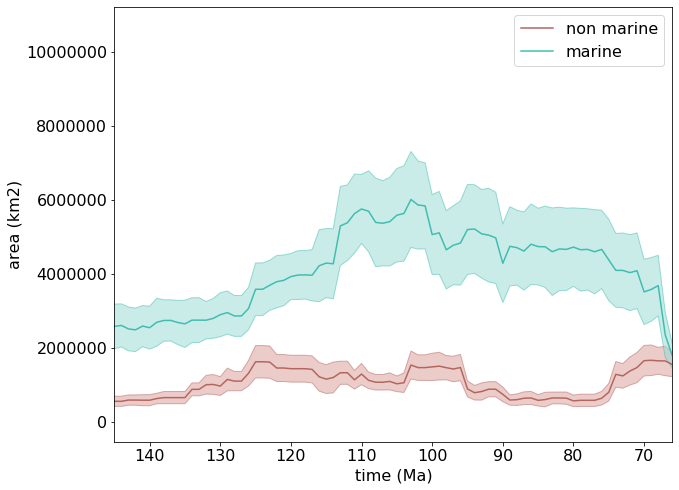

In [8]:
# Plot the time series data for the spatial coverage of both marine and non-marine environment
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(ts_non_marine['time'], ts_non_marine['area_mean'], label = 'non marine',color='#b36660') 
ax.plot(ts_marine['time'], ts_marine['area_mean'], label = 'marine',color='#40bdb0') 
ax.fill_between(ts_non_marine['time'], ts_non_marine['area_mean']-ts_non_marine['area_std'], ts_non_marine['area_mean']+ts_non_marine['area_std'],
    alpha=0.5, edgecolor='#b36660', facecolor='#db9a95')
ax.fill_between(ts_marine['time'], ts_marine['area_mean']-ts_marine['area_std'], ts_marine['area_mean']+ts_marine['area_std'],
    alpha=0.5, edgecolor='#40bdb0', facecolor='#95dbd4')
ax.set_xlim(145,66)
ax.legend(fontsize = 16)
ax.set_xlabel("time (Ma)",fontsize = 16)
ax.set_ylabel("area (km2)",fontsize = 16)
ax.ticklabel_format(style='plain')
ax.tick_params( labelsize=16)

#### 2. Processing and visualizing time series of siliciclastic and carbonate coverages in Phanerozoic
Macrostrat database is pretty big. Depending on your computer's capability and the specific variable you request in the API, the bootstrapping sampling could take several minutes.

In [9]:
# Retriving the siliciclastic data via the Macrostrat API
api_sil = 'https://macrostrat.org/api/units?lith_type=siliciclastic&project_id=1&response=long'
# Processing the API and get the raw column data
df_sil = col_json_proc(api_sil)
# Converting the raw column data into the time series data, with 5 iterations for bootstrapping
ts_sil = get_time_series(df_sil, 5)
# Preview the time series data
ts_sil

,time,col_mean,col_std,package_mean,package_std,area_mean,area_std
0,1,384.0,80.152355,524.2,8.657944,9.095427e+06,2.136334e+06
1,2,363.8,74.547703,505.6,8.708616,8.151908e+06,1.940202e+06
2,3,149.4,29.247906,210.6,11.038116,3.165299e+06,5.914352e+05
3,4,167.6,41.156287,228.8,10.609430,3.454461e+06,8.298879e+05
4,5,157.2,37.461447,220.0,5.796551,3.503530e+06,7.858647e+05
...,...,...,...,...,...,...,...
535,536,63.0,14.113823,83.0,4.289522,1.080437e+06,1.909944e+05
536,537,60.6,14.263239,79.4,1.854724,1.024080e+06,2.071629e+05
537,538,57.8,14.133648,74.6,3.555278,9.564772e+05,2.012853e+05
538,539,57.4,13.573504,75.0,3.847077,9.445372e+05,2.048563e+05


In [10]:
# Retriving the carbonate data via the Macrostrat API
api_carb = 'https://macrostrat.org/api/units?lith_type=carbonate&project_id=1&response=long'
# Processing the API and get the raw column data
df_carb = col_json_proc(api_carb)
# Converting the raw column data into the time series data, with 5 iterations for bootstrapping
ts_carb = get_time_series(df_carb, 5)
# Preview the time series data
ts_carb

,time,col_mean,col_std,package_mean,package_std,area_mean,area_std
0,1,7.6,1.743560,11.2,2.925748,271114.154483,64068.766828
1,2,8.0,1.897367,10.4,2.059126,277146.095300,92622.084946
2,3,8.0,1.264911,11.0,2.756810,328480.098467,28437.630626
3,4,13.4,2.870540,16.4,2.576820,419778.921600,91540.149909
4,5,8.8,1.939072,10.8,2.638181,346358.566600,40934.384384
...,...,...,...,...,...,...,...
535,536,25.8,6.013319,32.8,1.939072,432269.435460,109353.213644
536,537,24.4,5.425864,31.2,0.979796,390636.512560,96266.014024
537,538,20.2,4.833218,25.0,3.286335,297372.025000,88039.843198
538,539,19.2,4.791659,23.8,3.059412,289184.514767,87934.728921


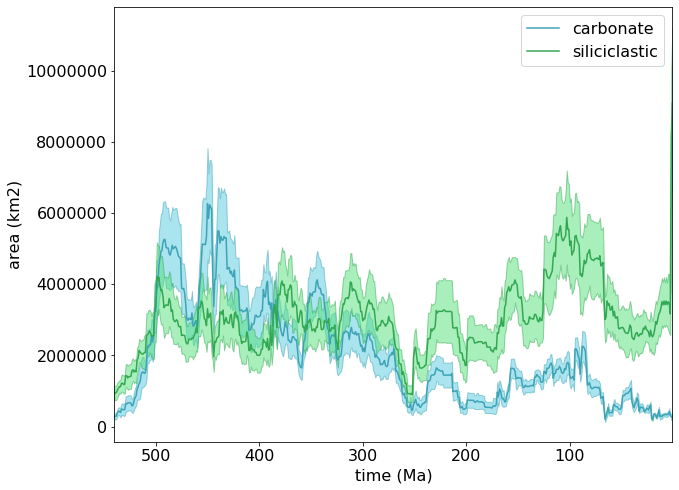

In [11]:
# Plot the time series data for the spatial coverage of both siliciclastic and carbonate
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(ts_carb['time'], ts_carb['area_mean'], label = 'carbonate',color='#3ea3b5') 
ax.plot(ts_sil['time'], ts_sil['area_mean'], label = 'siliciclastic',color='#32a852') 
ax.fill_between(ts_carb['time'], ts_carb['area_mean']-ts_carb['area_std'], ts_carb['area_mean']+ts_carb['area_std'],
    alpha=0.5, edgecolor='#3ea3b5', facecolor='#55cbe0')
ax.fill_between(ts_sil['time'], ts_sil['area_mean']-ts_sil['area_std'], ts_sil['area_mean']+ts_sil['area_std'],
    alpha=0.5, edgecolor='#32a852', facecolor='#55e07b')
ax.set_xlim(540,1)
ax.legend(fontsize = 16)
ax.set_xlabel("time (Ma)",fontsize = 16)
ax.set_ylabel("area (km2)",fontsize = 16)
ax.ticklabel_format(style='plain')
ax.tick_params( labelsize=16)

#### 3. Mapping the spatial coverage of non-marine environment at 1 Ma

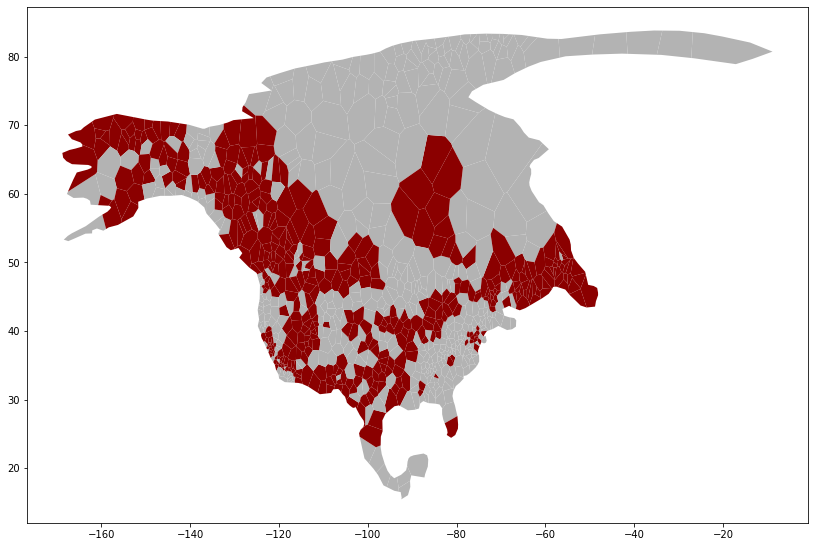

In [13]:
api = 'https://macrostrat.org/api/units?environ_class=non-marine&project_id=1&response=long'
age = 1
plot_col(api, age, "darkred")

# References
The Macrostrat database: https://macrostrat.org/
